In [17]:
## Basic imports for worling with paths
import os
import sys

## Custom package modules
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.calc import coupled_dipoles_copy as cpc
from misloc_mispol_package.optics import anal_foc_diff_fields as afi
from misloc_mispol_package.optics import diffraction_int as diffi
    
import numpy as np
## For fitting
import scipy.optimize as opt
## For loading matlab files 
import scipy.io as sio
from scipy.constants import physical_constants

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable
## Instructions for adding colorbar to axes 
#     ## Add colorbar
#     divider = make_axes_locatable(axs[ax_idx])
#     cax1 = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(img1, cax=cax1)

## Useful unit conversion
m_per_nm = fit.m_per_nm

In [18]:
exp_obs_pts = diffi.observation_points(0, 48*20*m_per_nm, 0, 48*20*m_per_nm, 21) ## cm_per_m

Load disk spectrum

In [19]:
disk_spec = sio.loadmat(
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "from_Biteen_group/sandwiched_nanodisk/nanodisk_spectrum_80nm_diameter.mat"
    )

(-1.0755921909917463, 2.3031352777205294)

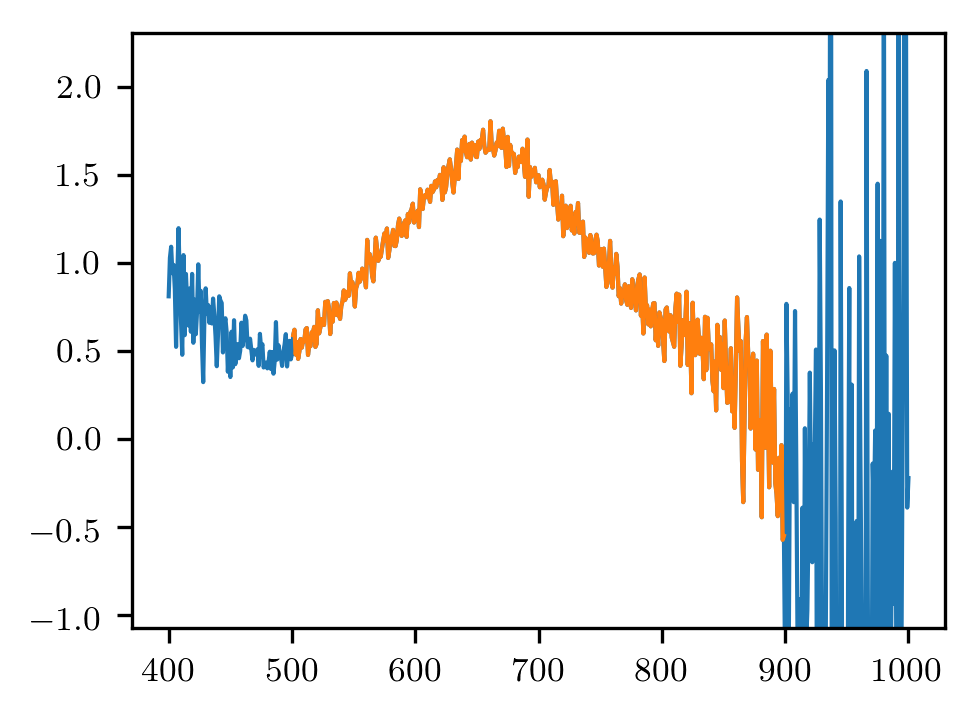

In [20]:
spectrum_idx_OI = np.argwhere(
    np.logical_and(
        disk_spec['spec'].T[0]<900,
        disk_spec['spec'].T[0]>500)
        )
fig_kwargs = {'lw':1}
plt.plot(*disk_spec['spec'].T, **fig_kwargs)
plt.plot(*disk_spec['spec'].T[:, spectrum_idx_OI], **fig_kwargs)
plt.ylim(
    np.min(disk_spec['spec'].T[1, spectrum_idx_OI])-.5,
    np.max(disk_spec['spec'].T[1, spectrum_idx_OI])+.5,
    )
    

In [84]:

hbar = physical_constants['Planck constant over 2 pi in eV s'][0]
c = physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
## DEFINE BACKGROUND FOR FITS
eps_b = 1.778
# eps_b=2

In [85]:
1.4**2

1.9599999999999997

In [86]:
hbarws = 1240/disk_spec['spec'].T[0, spectrum_idx_OI]
oblate_spec_data = disk_spec['spec'].T[1, spectrum_idx_OI]

## ----

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, height, diameter):
    
    a_x = height / 2
    a_yz = diameter / 2
    
    return cpc.long_sigma_scat_ret_pro_ellip(
        hbarw/hbar, 
        eps_inf, 
        hbarw_p/hbar, 
        hbargamma/hbar, 
        eps_b, 
        a_x*m_per_nm, 
        a_yz*m_per_nm)


In [125]:
#+++++++++++++++++++++++++++++++++++++++++++++
def oblate_cost_func(params, *args):
    x=args[0]
    y=args[1]

    
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    y_normed = y/y.max()
    yfit_normed = oblate_fit_result(x, params)

    low_energy_forgiveness = np.ones(x.shape) - (x<1.6) * .1
    return (y_normed-yfit_normed).ravel()*low_energy_forgiveness.ravel()

def oblate_fit_result(x, params):
    
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(x, *phys_params)
    
    return yfit/yfit.max() * amp

In [192]:
#+++++++++++++++++++++++++++++++++++++++++++++
ini_guess_both=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972, .9])
# ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, oblate_spec_data,]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    oblate_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  20,  60, 0.75],
        [18, 20, 1,  31,  80, 1.25],
        ),
    x_scale=[10,10,1E-1,10, 10, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = oblate_fit_result(hbarws, result['x'])
# norm_fit_result = fit_result/fit_result.max()

# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)



In [193]:
fit_params_8 = result['x']

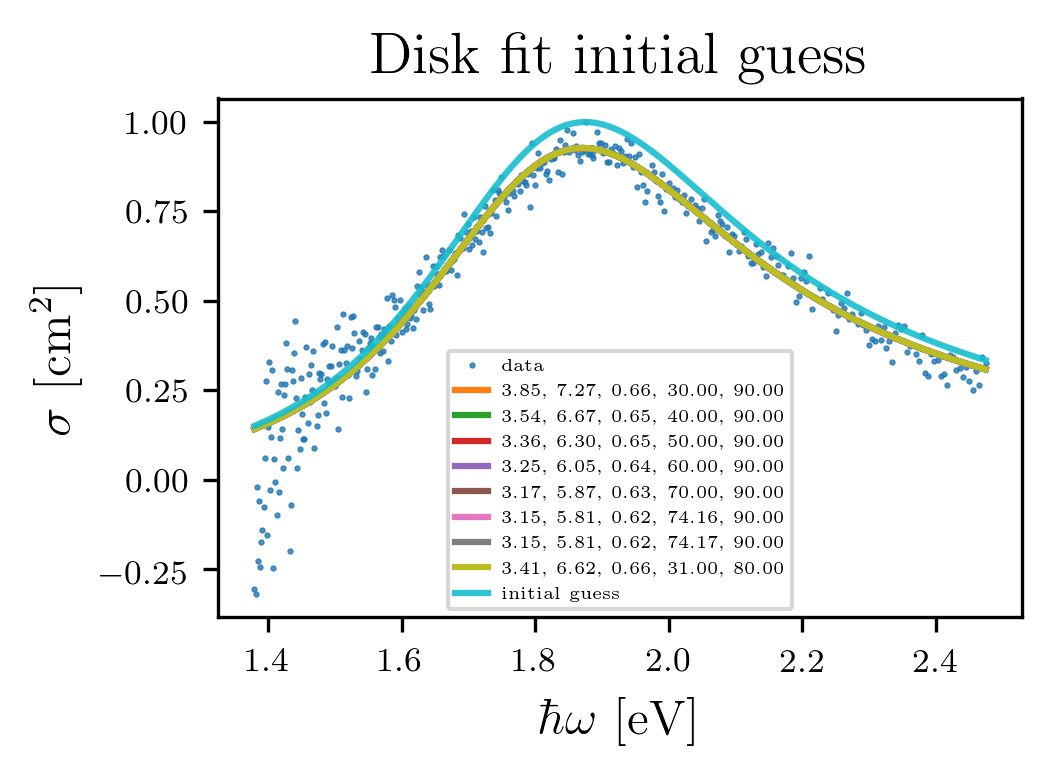

In [194]:
# plt.figure(dpi=100)
norm_data = oblate_spec_data/oblate_spec_data.max()

plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.', markersize=1, alpha=.9)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
for i, fit_params in enumerate([
    fit_params_1,
    fit_params_2,
    fit_params_3,
    fit_params_4,
    fit_params_5,
    fit_params_6,
    fit_params_7,
    fit_params_8,]):
    
    fit_result = oblate_fit_result(hbarws, fit_params)
    
    plt.plot(hbarws, fit_result,label=f'{fit_params[0]:.2f}, {fit_params[1]:.2f}, {fit_params[2]:.2f}, {fit_params[3]:.2f}, {fit_params[4]:.2f}', ls='-')
# plt.plot(hbarws, oblate_cost_func(ini_guess_both, *args), label='initial cost func',
#         ls=' ', marker='.', markersize=1, alpha=.9)

ini_guess = ret_fit_scat_1(
    hbarws, 
    ini_guess_both[0], 
    ini_guess_both[1], 
    ini_guess_both[2], 
    ini_guess_both[3], 
    ini_guess_both[4])
plt.plot(
    hbarws, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()
plt.tight_layout()

In [211]:
#+++++++++++++++++++++++++++++++++++++++++++++
ini_guess_both=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972, .9])
# ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, oblate_spec_data,]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    oblate_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  20,  60, 0.75],
        [18, 20, 1,  71,  80, 1.25],
        ),
    x_scale=[10,10,1E-1,10, 10, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = oblate_fit_result(hbarws, result['x'])
# norm_fit_result = fit_result/fit_result.max()

# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)



In [212]:
fit_params_5 = result['x']

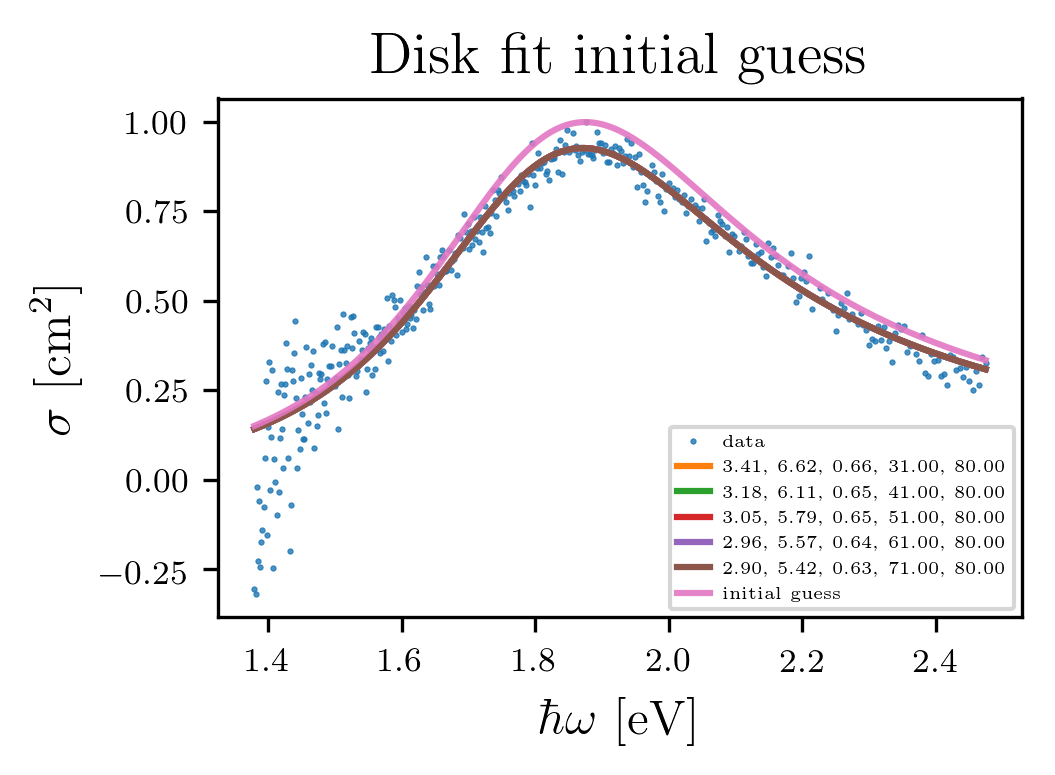

In [213]:
# plt.figure(dpi=100)
norm_data = oblate_spec_data/oblate_spec_data.max()

plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.', markersize=1, alpha=.9)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
for i, fit_params in enumerate([
    fit_params_1,
    fit_params_2,
    fit_params_3,
    fit_params_4,
    fit_params_5,]):
    
    fit_result = oblate_fit_result(hbarws, fit_params)
    
    plt.plot(hbarws, fit_result,label=f'{fit_params[0]:.2f}, {fit_params[1]:.2f}, {fit_params[2]:.2f}, {fit_params[3]:.2f}, {fit_params[4]:.2f}', ls='-')
# plt.plot(hbarws, oblate_cost_func(ini_guess_both, *args), label='initial cost func',
#         ls=' ', marker='.', markersize=1, alpha=.9)

ini_guess = ret_fit_scat_1(
    hbarws, 
    ini_guess_both[0], 
    ini_guess_both[1], 
    ini_guess_both[2], 
    ini_guess_both[3], 
    ini_guess_both[4])
plt.plot(
    hbarws, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()
plt.tight_layout()

In [231]:
#+++++++++++++++++++++++++++++++++++++++++++++
ini_guess_both=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 31.24119972, .9])
# ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972, .9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, oblate_spec_data,]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    oblate_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  20,  31, 0.75],
        [18, 20, 1,  30,  120, 1.25],
        ),
    x_scale=[10,10,1E-1,10, 10, 1],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = oblate_fit_result(hbarws, result['x'])
# norm_fit_result = fit_result/fit_result.max()

# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)



In [232]:
fit_params_9 = result['x']

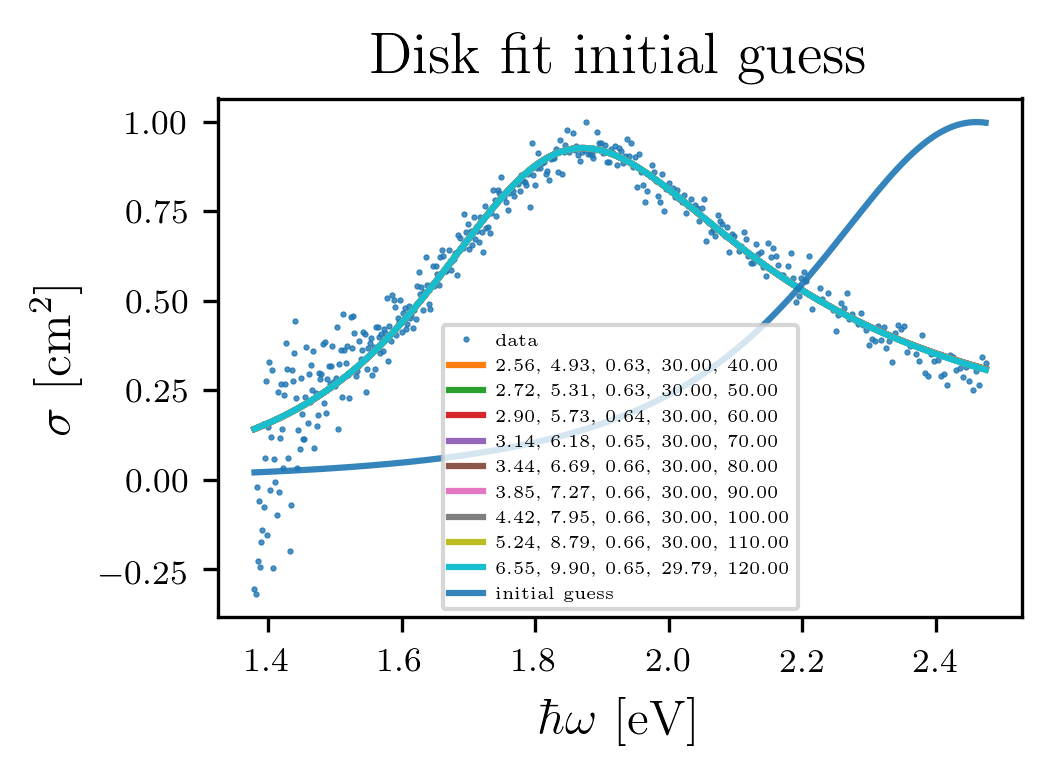

In [233]:
# plt.figure(dpi=100)
norm_data = oblate_spec_data/oblate_spec_data.max()

plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.', markersize=1, alpha=.9)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
for i, fit_params in enumerate([
    fit_params_1,
    fit_params_2,
    fit_params_3,
    fit_params_4,
    fit_params_5,
    fit_params_6,
    fit_params_7,
    fit_params_8,
    fit_params_9,]):
    
    fit_result = oblate_fit_result(hbarws, fit_params)
    
    plt.plot(hbarws, fit_result,label=f'{fit_params[0]:.2f}, {fit_params[1]:.2f}, {fit_params[2]:.2f}, {fit_params[3]:.2f}, {fit_params[4]:.2f}', ls='-')
# plt.plot(hbarws, oblate_cost_func(ini_guess_both, *args), label='initial cost func',
#         ls=' ', marker='.', markersize=1, alpha=.9)

ini_guess = ret_fit_scat_1(
    hbarws, 
    ini_guess_both[0], 
    ini_guess_both[1], 
    ini_guess_both[2], 
    ini_guess_both[3], 
    ini_guess_both[4])
plt.plot(
    hbarws, 
    ini_guess/ini_guess.max(), 
    label='initial guess',
#     ls=' ', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Disk fit initial guess ')
plt.legend(fontsize=4)

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()
plt.tight_layout()